In [135]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

telco_customer = pd.read_csv('Telco_preprocessing.csv')

In [105]:
import warnings

warnings.filterwarnings('ignore')

In [106]:
telco_customer.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,internet_cnt
0,0,7590-VHVEG,Female,0,Yes,No,1,No,DSL,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,1,5575-GNVDE,Male,0,No,No,34,Yes,DSL,One year,No,Mailed check,56.95,1889.50,No,2
2,2,3668-QPYBK,Male,0,No,No,2,Yes,DSL,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2
3,3,7795-CFOCW,Male,0,No,No,45,No,DSL,One year,No,Bank transfer (automatic),42.30,1840.75,No,3
4,4,9237-HQITU,Female,0,No,No,2,Yes,Fiber optic,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [136]:
telco_customer[['PhoneService', 'Churn']].value_counts()

PhoneService  Churn
Yes           No       4653
              Yes      1699
No            No        510
              Yes       170
Name: count, dtype: int64

### 변수 분류

In [108]:
numeric_df = telco_customer[['tenure', 'MonthlyCharges', 'TotalCharges', 'internet_cnt']]
category_df = telco_customer[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'PaperlessBilling', 'PaymentMethod']]
time_df = telco_customer[['Contract']]
y_column = telco_customer['Churn']

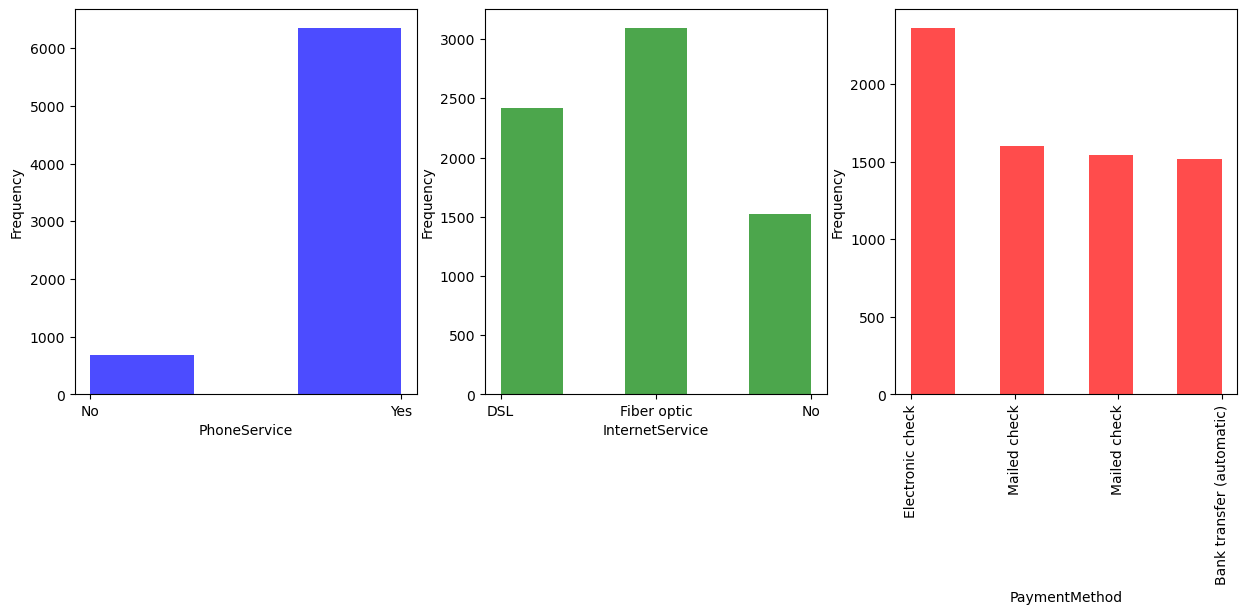

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# 각 서브플롯에 히스토그램 그리기
axs[0].hist(category_df['PhoneService'], bins=3, color='blue', alpha=0.7)
axs[0].set_xlabel('PhoneService')
axs[0].set_ylabel('Frequency')

axs[1].hist(category_df['InternetService'], bins=5, color='green', alpha=0.7)
axs[1].set_xlabel('InternetService')
axs[1].set_ylabel('Frequency')

axs[2].hist(category_df['PaymentMethod'], bins=7, color='red', alpha=0.7)
axs[2].set_xlabel('PaymentMethod')
axs[2].set_xticklabels(category_df['PaymentMethod'], rotation=90)
axs[2].set_ylabel('Frequency')

plt.show()

## 인코딩
### 인코딩 방식을 여러 개로 나눠서 진행하기
1. Contract를 우선 순위 없이 원핫인코딩으로 진행
2. Contract를 우선 순위를 고려하여 month < one year < two year로 레이블인코딩 하기

In [110]:
# 종속변수는 그냥 0, 1로 인코딩
y_column.replace(to_replace='Yes', value=1, inplace=True)
y_column.replace(to_replace='No', value=0, inplace=True)

### 원핫인코딩으로 진행

In [111]:
binary_class_category_df = category_df[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']]
multi_class_category_df = category_df[['InternetService', 'PaymentMethod']] # 원핫

In [112]:
binary_class_category_df = binary_class_category_df.replace(to_replace='Yes', value=1)
binary_class_category_df = binary_class_category_df.replace(to_replace='No', value=0)
binary_class_category_df = binary_class_category_df.replace(to_replace='Male', value=1)
binary_class_category_df = binary_class_category_df.replace(to_replace='Female', value=0)

In [113]:
# 방법 2에선 이 부분을 다르게
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
one_hot_encoded = encoder.fit_transform(multi_class_category_df)
multi_class_category_df_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())

In [114]:
# 크래머V 사용
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

## 상관관계 분석

### 새로 만든 컬럼에 대한 추가적인 확인이 필요

In [115]:
numeric_y = pd.concat([y_column, numeric_df], axis=1)

In [116]:
columns = numeric_y.columns
corr = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            corr.loc[col1, col2] = cramers_v(numeric_y[col1], numeric_y[col2])
        else:
            corr.loc[col1, col2] = 1.0

corr

,Churn,tenure,MonthlyCharges,TotalCharges,internet_cnt
Churn,1.000000,0.375104,0.276009,0.000000,0.233408
tenure,0.375104,1.000000,0.084899,0.206289,0.264779
MonthlyCharges,0.276009,0.084899,1.000000,0.366105,0.582470
TotalCharges,0.000000,0.206289,0.366105,1.000000,0.202492
internet_cnt,0.233408,0.264779,0.582470,0.202492,1.000000


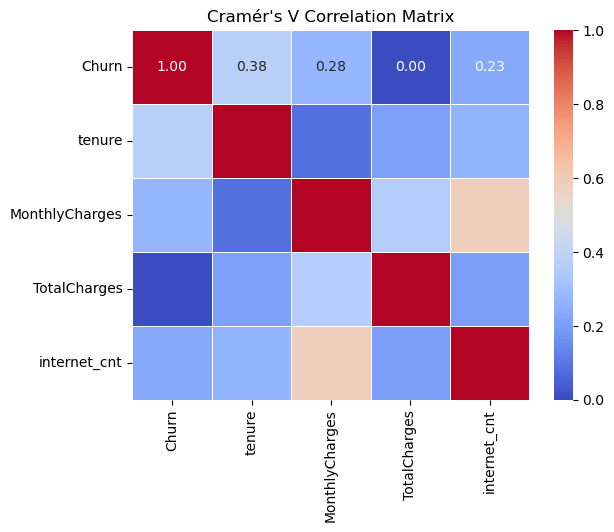

In [117]:
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Cramér\'s V Correlation Matrix')
plt.show()

#### 개수로 했을 때 크게 다르지 않아서 인터넷 서비스 가입 여부에 따라 다시 해봄

In [118]:
numeric_y['internet_cnt'] = np.where(numeric_y['internet_cnt'] > 0, 1, 0)

<Axes: xlabel='internet_cnt', ylabel='Count'>

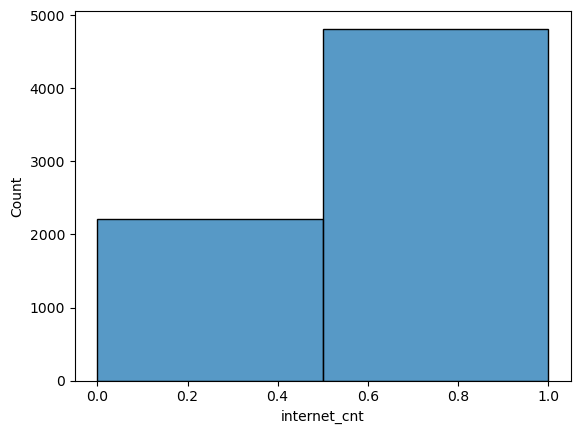

In [119]:
sns.histplot(numeric_y['internet_cnt'], bins=2)

In [120]:
columns = numeric_y.columns
corr = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            corr.loc[col1, col2] = cramers_v(numeric_y[col1], numeric_y[col2])
        else:
            corr.loc[col1, col2] = 1.0

corr

,Churn,tenure,MonthlyCharges,TotalCharges,internet_cnt
Churn,1.000000,0.375104,0.276009,0.000000,0.077200
tenure,0.375104,1.000000,0.084899,0.206289,0.261484
MonthlyCharges,0.276009,0.084899,1.000000,0.366105,0.794801
TotalCharges,0.000000,0.206289,0.366105,1.000000,0.153737
internet_cnt,0.077200,0.261484,0.794801,0.153737,1.000000


***더 낮은 수치가 나와서 그냥 count로 하는게 나을 듯***

## 1번 방식으로 진행 - 원핫인코딩

In [121]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
one_hot_encoded = encoder.fit_transform(time_df)
time_df_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())
time_df_encoded = time_df_encoded.astype('int64')

### 분류모델 적용하기

In [122]:
# 데이터 분할 -> 나중에 적용할 때 팀이 같은 데이터 분할이 적용되도록 해야하나 생각(물어보기)
from sklearn.model_selection import train_test_split

X = pd.concat([numeric_y, time_df_encoded, multi_class_category_df_encoded, binary_class_category_df], axis=1)
X.drop('Churn', axis=1, inplace=True)
y = y_column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 로지스틱 회귀 모델 사용

In [123]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

# 학습된 모델의 계수(coefficients) 및 절편(intercept) 출력
coefficients = logistic_reg.coef_
intercept = logistic_reg.intercept_

print('#'*20, '학습된 파라미터 값', '#'*20)
print(coefficients)

print('#'*20, '학습된 절편 값', '#'*20)
print(intercept)

#################### 학습된 파라미터 값 ####################
[[-6.67374362e-02  3.92064815e-03  3.67747180e-04 -6.10591699e-02
   5.59450633e-01 -3.87390223e-01 -5.16042729e-01 -2.86153959e-01
   4.61125629e-01 -5.18953988e-01 -9.86025253e-02 -2.50782604e-01
   3.21704578e-01 -3.16301768e-01  2.58771781e-02  4.04919628e-01
   5.92095183e-02 -2.88747443e-01 -5.88459705e-01  3.96833139e-01]]
#################### 학습된 절편 값 ####################
[-0.34607665]


#### 학습 평가 - Confusion matrix

In [124]:
from sklearn.metrics import accuracy_score

y_train_pred = logistic_reg.predict(X_train)
y_test_pred = logistic_reg.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'학습 데이터를 이용한 Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 Acc 값 : {acc_test*100:.1f}%')

학습 데이터를 이용한 Acc 값 : 80.5%
평가 데이터를 이용한 Acc 값 : 78.7%


#### 학습 데이터를 활용한 confusion matrix

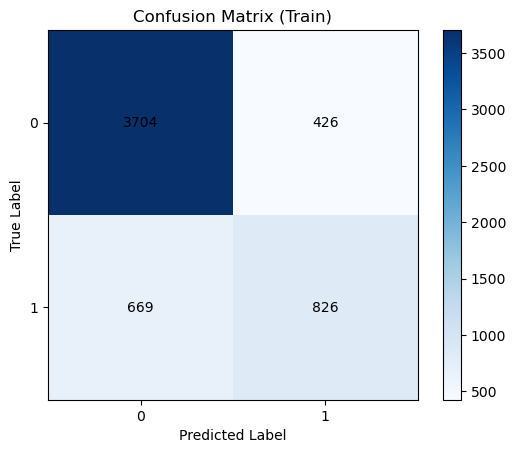

In [125]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.imshow(cm_train, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Train)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train)))
plt.xticks(tick_marks, np.unique(y_train))
plt.yticks(tick_marks, np.unique(y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        plt.text(j, i, cm_train[i, j], ha="center", va="center", color="black")

#### 평가 데이터를 활용한 confusion matrix

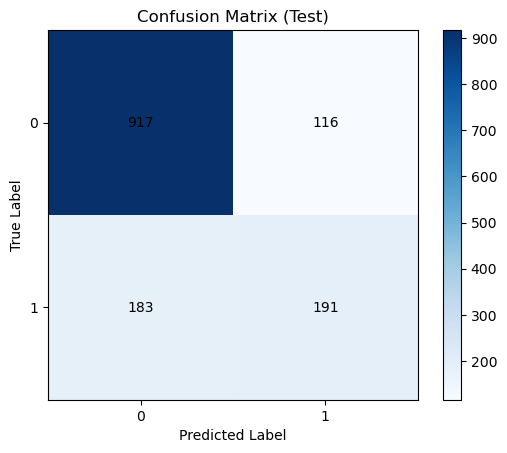

In [126]:
plt.imshow(cm_test, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        plt.text(j, i, cm_test[i, j], ha="center", va="center", color="black")

In [127]:
coeff_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': logistic_reg.coef_.flatten()})

# 계수의 절대값을 기준으로 내림차순 정렬
coeff_df['abs_coefficient'] = coeff_df['coefficient'].abs()
coeff_df_sorted = coeff_df.sort_values(by='abs_coefficient', ascending=False)

# 변수의 영향력을 확인
coeff_df_sorted

,feature,coefficient,abs_coefficient
18,PhoneService,-0.588460,0.588460
4,Contract_Month-to-month,0.559451,0.559451
9,InternetService_No,-0.518954,0.518954
6,Contract_Two year,-0.516043,0.516043
8,InternetService_Fiber optic,0.461126,0.461126
15,SeniorCitizen,0.404920,0.404920
19,PaperlessBilling,0.396833,0.396833
5,Contract_One year,-0.387390,0.387390
12,PaymentMethod_Electronic check,0.321705,0.321705
13,PaymentMethod_Mailed check,-0.316302,0.316302


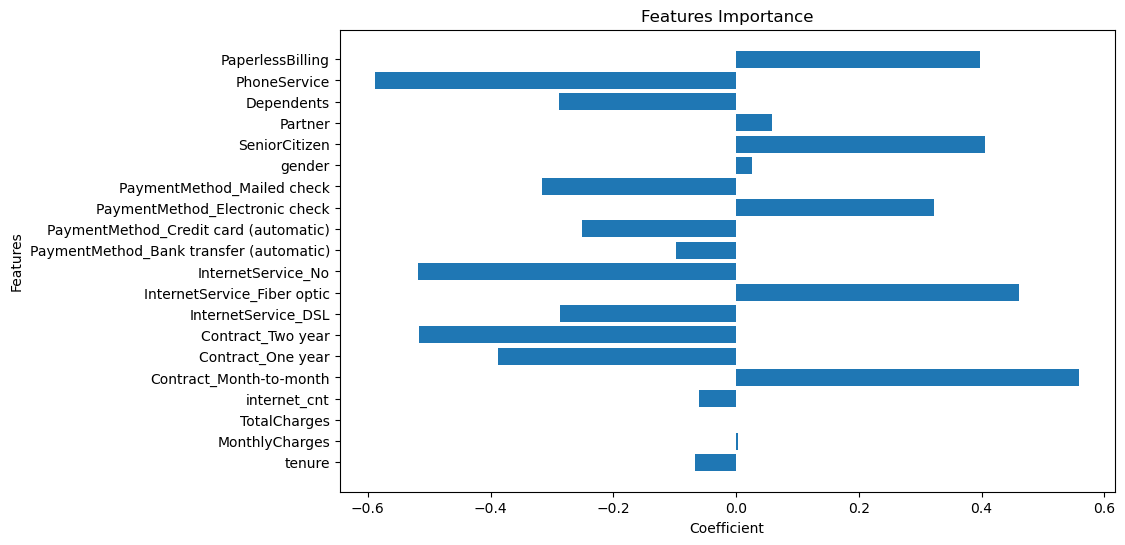

In [128]:
# 변수 영향력 시각화
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, logistic_reg.coef_.flatten())
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Features Importance')
plt.show()

### 소프트벡터머신 돌리기

#### 하이퍼 파라미터 변경해보기
- kernel
- C

In [129]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=0.1)

In [130]:
svm.fit(X_train, y_train)

SVC(C=0.1)

In [131]:
# 예측 수행
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm = svm.predict(X_test)

# 평가 지표 계산: 정확도 (맞은수/전체)
acc_train = accuracy_score(y_train, y_train_pred_svm)
acc_test = accuracy_score(y_test, y_test_pred_svm)

print(f'학습 데이터를 이용한 SVM Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 SVM Acc 값 : {acc_test*100:.1f}%')

학습 데이터를 이용한 SVM Acc 값 : 73.4%
평가 데이터를 이용한 SVM Acc 값 : 73.4%


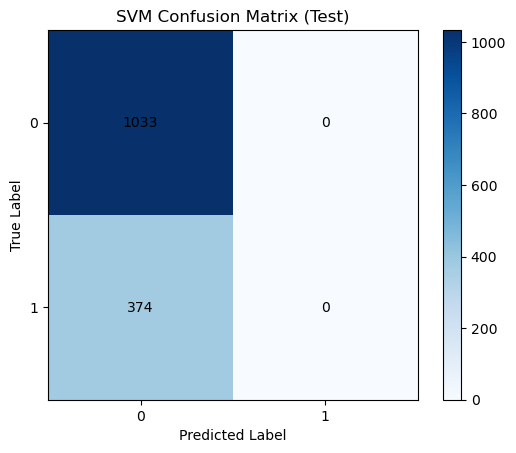

In [132]:
# confusion matrix을 활용한 평가 결과 확인
cm_test_svm = confusion_matrix(y_test, y_test_pred_svm)

plt.imshow(cm_test_svm, interpolation='nearest', cmap='Blues')
plt.title("SVM Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test_svm.shape[0]):
    for j in range(cm_test_svm.shape[1]):
        plt.text(j, i, cm_test_svm[i, j], ha="center", va="center", color="black")

In [133]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

svm_precision = precision_score(y_test, y_test_pred_svm)
svm_recall = recall_score(y_test, y_test_pred_svm)
svm_f1 = f1_score(y_test, y_test_pred_svm)
print(f'SVM의 P,R,F1 : {svm_precision:.2f} / {svm_recall:.2f} / {svm_f1:.2f}')

SVM의 P,R,F1 : 0.00 / 0.00 / 0.00


#### 최적의 파라미터 찾기

In [ ]:
# 실행시간이 오래 걸리는지 계속 해도 안되길래 나중에 구글 코랩에서 GPU로 돌려보기
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf']
# }

# grid_search = GridSearchCV(SVC(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

### Decision Tree 사용

#### 하이퍼 파라미터 적용해보기
- criterion
- max_depth
- min_samples_split

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='log_loss',
                            max_depth=5,
                            min_samples_split=10)

In [ ]:
dt.fit(X_train, y_train)

In [ ]:
# 예측 수행
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

# 평가 지표 계산: 정확도 (맞은수/전체)
acc_train = accuracy_score(y_train, y_train_pred_dt)
acc_test = accuracy_score(y_test, y_test_pred_dt)

print(f'학습 데이터를 이용한 DT Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 DT Acc 값 : {acc_test*100:.1f}%')

In [ ]:
# confusion matrix을 활용한 평가 결과 확인
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt)

plt.imshow(cm_test_dt, interpolation='nearest', cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test_dt.shape[0]):
    for j in range(cm_test_dt.shape[1]):
        plt.text(j, i, cm_test_dt[i, j], ha="center", va="center", color="black")

In [ ]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

dt_precision = precision_score(y_test, y_test_pred_dt)
dt_recall = recall_score(y_test, y_test_pred_dt)
dt_f1 = f1_score(y_test, y_test_pred_dt)
print(f'DT의 P,R,F1 : {dt_precision:.2f} / {dt_recall:.2f} / {dt_f1:.2f}')

### 랜덤 포레스트 사용

#### 하이퍼 파라미터
- n_estimators

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
# 예측 수행
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# 평가 지표 계산: 정확도 (맞은수/전체)
acc_train = accuracy_score(y_train, y_train_pred_rf)
acc_test = accuracy_score(y_test, y_test_pred_rf)

print(f'학습 데이터를 이용한 RF Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 RF Acc 값 : {acc_test*100:.1f}%')

In [ ]:
# confusion matrix을 활용한 평가 결과 확인
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)

plt.imshow(cm_test_rf, interpolation='nearest', cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test_rf.shape[0]):
    for j in range(cm_test_rf.shape[1]):
        plt.text(j, i, cm_test_rf[i, j], ha="center", va="center", color="black")

## 2번 방식으로 진행 - 라벨인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
label_encoded = encoder.fit_transform(time_df)
time_df_label_encoded = pd.DataFrame(label_encoded, columns=['Contract'])
time_df_label_encoded = time_df_label_encoded.astype('int64')

### 분류모델 적용하기

In [ ]:
# 데이터 분할 -> 나중에 적용할 때 팀이 같은 데이터 분할이 적용되도록 해야하나 생각(물어보기)
from sklearn.model_selection import train_test_split

X = pd.concat([numeric_y, time_df_label_encoded, multi_class_category_df_encoded, binary_class_category_df], axis=1)
X.drop('Churn', axis=1, inplace=True)
y = y_column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 로지스틱 회귀 모델 사용

#### 하이퍼 파라미터
- penalty
- C

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

# 학습된 모델의 계수(coefficients) 및 절편(intercept) 출력
coefficients = logistic_reg.coef_
intercept = logistic_reg.intercept_

print('#'*20, '학습된 파라미터 값', '#'*20)
print(coefficients)

print('#'*20, '학습된 절편 값', '#'*20)
print(intercept)

#### 학습 평가 - Confusion matrix

In [206]:
from sklearn.metrics import accuracy_score

y_train_pred = logistic_reg.predict(X_train)
y_test_pred = logistic_reg.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'학습 데이터를 이용한 Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 Acc 값 : {acc_test*100:.1f}%')

학습 데이터를 이용한 Acc 값 : 80.5%
평가 데이터를 이용한 Acc 값 : 78.7%


#### 학습 데이터를 활용한 confusion matrix

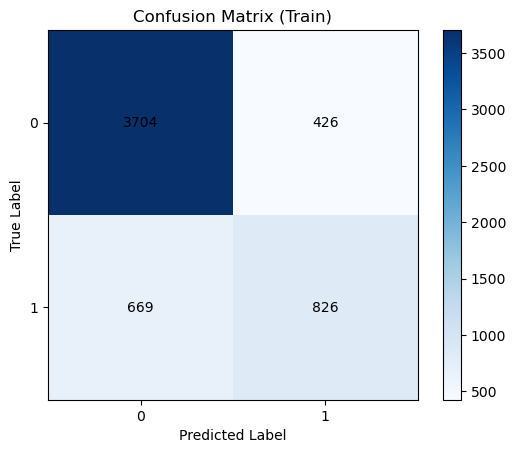

In [205]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.imshow(cm_train, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Train)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train)))
plt.xticks(tick_marks, np.unique(y_train))
plt.yticks(tick_marks, np.unique(y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        plt.text(j, i, cm_train[i, j], ha="center", va="center", color="black")

#### 평가 데이터를 활용한 confusion matrix

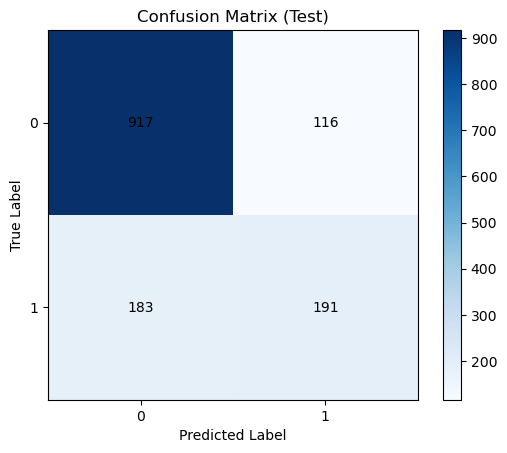

In [207]:
plt.imshow(cm_test, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        plt.text(j, i, cm_test[i, j], ha="center", va="center", color="black")

In [ ]:
coeff_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': logistic_reg.coef_.flatten()})

# 계수의 절대값을 기준으로 내림차순 정렬
coeff_df['abs_coefficient'] = coeff_df['coefficient'].abs()
coeff_df_sorted = coeff_df.sort_values(by='abs_coefficient', ascending=False)

# 변수의 영향력을 확인
coeff_df_sorted

In [ ]:
# 변수 영향력 시각화
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, logistic_reg.coef_.flatten())
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Features Importance')
plt.show()

In [ ]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
print(f'Logistic Regression train의 P,R,F1 : {precision_train:.2f} / {recall_train:.2f} / {f1_train:.2f}')

precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f'Logistic Regression test의 P,R,F1 : {precision_test:.2f} / {recall_test:.2f} / {f1_test:.2f}')

### 소프트벡터머신 돌리기

#### 하이퍼 파라미터 변경해보기
- kernel
- C

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=0.1)

In [ ]:
svm.fit(X_train, y_train)

In [ ]:
# 예측 수행
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm = svm.predict(X_test)

# 평가 지표 계산: 정확도 (맞은수/전체)
acc_train = accuracy_score(y_train, y_train_pred_svm)
acc_test = accuracy_score(y_test, y_test_pred_svm)

print(f'학습 데이터를 이용한 SVM Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 SVM Acc 값 : {acc_test*100:.1f}%')

In [ ]:
# confusion matrix을 활용한 평가 결과 확인
cm_test_svm = confusion_matrix(y_test, y_test_pred_svm)

plt.imshow(cm_test_svm, interpolation='nearest', cmap='Blues')
plt.title("SVM Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test_svm.shape[0]):
    for j in range(cm_test_svm.shape[1]):
        plt.text(j, i, cm_test_svm[i, j], ha="center", va="center", color="black")

In [ ]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

svm_precision_train = precision_score(y_train, y_train_pred_svm)
svm_recall_train = recall_score(y_train, y_train_pred_svm)
svm_f1_train = f1_score(y_train, y_train_pred_svm)
print(f'SVM_train의 P,R,F1 : {svm_precision_train:.2f} / {svm_recall_train:.2f} / {svm_f1_train:.2f}')

svm_precision_test = precision_score(y_test, y_test_pred_svm)
svm_recall_test = recall_score(y_test, y_test_pred_svm)
svm_f1_test = f1_score(y_test, y_test_pred_svm)
print(f'SVM_test의 P,R,F1 : {svm_precision_test:.2f} / {svm_recall_test:.2f} / {svm_f1_test:.2f}')

### Decision Tree 사용

#### 하이퍼 파라미터 적용해보기
- criterion
- max_depth
- min_samples_split

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini',
                            max_depth=5,
                            min_samples_split=10)

In [ ]:
dt.fit(X_train, y_train)

In [ ]:
# 예측 수행
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

# 평가 지표 계산: 정확도 (맞은수/전체)
acc_train = accuracy_score(y_train, y_train_pred_dt)
acc_test = accuracy_score(y_test, y_test_pred_dt)

print(f'학습 데이터를 이용한 DT Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 DT Acc 값 : {acc_test*100:.1f}%')

In [ ]:
X_train.columns

In [ ]:
importances = dt.feature_importances_

# 중요도를 출력합니다
for i, importance in enumerate(importances):
    print(f"Feature {i}: Importance = {importance}")

In [ ]:
# confusion matrix을 활용한 평가 결과 확인
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt)

plt.imshow(cm_test_dt, interpolation='nearest', cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test_dt.shape[0]):
    for j in range(cm_test_dt.shape[1]):
        plt.text(j, i, cm_test_dt[i, j], ha="center", va="center", color="black")

In [ ]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

dt_precision_train = precision_score(y_train, y_train_pred_dt)
dt_recall_train = recall_score(y_train, y_train_pred_dt)
dt_f1_train = f1_score(y_train, y_train_pred_dt)
print(f'DT_train의 P,R,F1 : {dt_precision_train:.2f} / {dt_recall_train:.2f} / {dt_f1_train:.2f}')

dt_precision_test = precision_score(y_test, y_test_pred_dt)
dt_recall_test = recall_score(y_test, y_test_pred_dt)
dt_f1_test = f1_score(y_test, y_test_pred_dt)
print(f'DT_test의 P,R,F1 : {dt_precision_test:.2f} / {dt_recall_test:.2f} / {dt_f1_test:.2f}')

In [ ]:
from sklearn.metrics import roc_auc_score

# 클래스 확률을 예측합니다
y_prob = dt.predict_proba(X_test)[:, 1] # 클래스 1의 확률을 사용합니다

# AUC를 계산합니다
auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

### 랜덤 포레스트 사용

#### 하이퍼 파라미터
- n_estimators
- max_depth
- min_samples_split
- min_samples_leaf
- max_features
- bootstrap
- random_state
- class_weight

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
# 예측 수행
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# 평가 지표 계산: 정확도 (맞은수/전체)
acc_train = accuracy_score(y_train, y_train_pred_rf)
acc_test = accuracy_score(y_test, y_test_pred_rf)

print(f'학습 데이터를 이용한 RF Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 RF Acc 값 : {acc_test*100:.1f}%')

In [ ]:
# confusion matrix을 활용한 평가 결과 확인
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)

plt.imshow(cm_test_rf, interpolation='nearest', cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test_rf.shape[0]):
    for j in range(cm_test_rf.shape[1]):
        plt.text(j, i, cm_test_rf[i, j], ha="center", va="center", color="black")

In [ ]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

rf_precision_train = precision_score(y_train, y_train_pred_rf)
rf_recall_train = recall_score(y_train, y_train_pred_rf)
rf_f1_train = f1_score(y_train, y_train_pred_rf)
print(f'RF_train의 P,R,F1 : {rf_precision_train:.2f} / {rf_recall_train:.2f} / {rf_f1_train:.2f}')

rf_precision_test = precision_score(y_test, y_test_pred_rf)
rf_recall_test = recall_score(y_test, y_test_pred_rf)
rf_f1_test = f1_score(y_test, y_test_pred_rf)
print(f'RF_test의 P,R,F1 : {dt_precision_test:.2f} / {dt_recall_test:.2f} / {dt_f1_test:.2f}')

### train, test 데이터 불균형 확인

In [ ]:
plt.hist(y_train, bins=3)

In [ ]:
plt.hist(y_test, bins=3)

In [ ]:
y_train.value_counts()[0] / len(y_train)

In [ ]:
y_train.value_counts()[1] / len(y_train)

In [ ]:
y_test.value_counts()[0] / len(y_test)

#### 데이터에 대한 오버샘플링

In [198]:
from sklearn.utils import resample

# 독립변수, 종속변수 지정 (X 부분은 각자가 한 부분으로 변형해서 사용하면 됩니다)
X = pd.concat([numeric_y, time_df_label_encoded, multi_class_category_df_encoded, binary_class_category_df], axis=1)
X.drop('Churn', axis=1, inplace=True)
y = y_column

# 1의 값을 가지는 샘플들과 0의 값을 가지는 샘플들로 분리
X_minority = X[y == 1]
X_majority = X[y == 0]
y_minority = y[y == 1]
y_majority = y[y == 0]

# 소수 클래스(1)에 해당하는 샘플들을 복원 추출하여 다수 클래스(0)의 샘플 수와 동일하게 오버샘플링
X_resampled, y_resampled = resample(X_minority,
                                    y_minority,
                                    replace=True,
                                    n_samples=X_majority.shape[0],  # 다수 클래스 샘플 수와 동일하게 오버샘플링
                                    random_state=42)
# 샘플링한 정보 데이터프레임으로 변환
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
X_balanced_train_df = pd.concat([pd.DataFrame(X_majority, columns=X.columns), X_resampled_df], axis=0, ignore_index=True)

y_resampled_df = np.concatenate((y_majority, y_resampled))
y_balanced_train_df = pd.DataFrame(y_resampled_df, columns=['Churn'])

In [199]:
# 독립변수, 종속변수 다시 합쳐서 저장
resampled_df = pd.concat([X_balanced_train_df, y_balanced_train_df], axis=1)
resampled_df.head()

,tenure,MonthlyCharges,TotalCharges,internet_cnt,Contract,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,1,29.85,29.85,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0,1,0
1,34,56.95,1889.50,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,1,0,0
2,45,42.30,1840.75,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0
3,22,89.10,1949.40,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,1,1,0
4,10,29.75,301.90,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0


In [202]:
resampled_df.to_csv('Telco_resampled.csv', index=False)

In [204]:
y.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

#### 간단하게 로지스틱만 돌려보기

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(x_balanced_train_df, y_balanced_train_df)

# 학습된 모델의 계수(coefficients) 및 절편(intercept) 출력
coefficients = logistic_reg.coef_
intercept = logistic_reg.intercept_

print('#'*20, '학습된 파라미터 값', '#'*20)
print(coefficients)

print('#'*20, '학습된 절편 값', '#'*20)
print(intercept)

In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = logistic_reg.predict(X_train)
y_test_pred = logistic_reg.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'학습 데이터를 이용한 Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 Acc 값 : {acc_test*100:.1f}%')

In [ ]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.imshow(cm_train, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Train)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train)))
plt.xticks(tick_marks, np.unique(y_train))
plt.yticks(tick_marks, np.unique(y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        plt.text(j, i, cm_train[i, j], ha="center", va="center", color="black")

In [ ]:
coeff_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': logistic_reg.coef_.flatten()})

# 계수의 절대값을 기준으로 내림차순 정렬
coeff_df['abs_coefficient'] = coeff_df['coefficient'].abs()
coeff_df_sorted = coeff_df.sort_values(by='abs_coefficient', ascending=False)

# 변수의 영향력을 확인
coeff_df_sorted

In [ ]:
# 변수 영향력 시각화
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, logistic_reg.coef_.flatten())
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Features Importance')
plt.show()

In [ ]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
print(f'Logistic Regression train의 P,R,F1 : {precision_train:.2f} / {recall_train:.2f} / {f1_train:.2f}')